In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from collections import OrderedDict

# Load the dataset
file_path = "ferry_tips_data.csv" 
trips_df = pd.read_csv(file_path)

# Define emission factor
EMISSION_FACTOR = 2.68  # Example for diesel

# Preprocess fuel data 
def preprocess_fuel_data(trips_df):
    trips_df["time_departure"] = pd.to_datetime(trips_df["time_departure"], errors="coerce")
    trips_df["hour"] = trips_df["time_departure"].dt.hour
    trips_df["minute"] = trips_df["time_departure"].dt.minute
    trips_df["weekday"] = trips_df["time_departure"].dt.weekday  # Add weekday column
    trips_df["fuelcons_outbound_l"] = trips_df["fuelcons_outbound_l"].replace(0, pd.NA).fillna(
        trips_df.groupby(["route_id", "hour", "minute"])["fuelcons_outbound_l"].transform("mean")
    )
    trips_df["fuelcons_inbound_l"] = trips_df["fuelcons_inbound_l"].replace(0, pd.NA).fillna(
        trips_df.groupby(["route_id", "hour", "minute"])["fuelcons_inbound_l"].transform("mean")
    )
    return trips_df

In [245]:
# Ensure `weekday` is added when filtering route data
def filter_route_data(trips_df, route_id, week_start, week_end):
    filtered_data = trips_df[
        (trips_df["route_id"] == route_id) &
        (trips_df["time_departure"].dt.date >= week_start) &
        (trips_df["time_departure"].dt.date <= week_end)
    ].copy()
    filtered_data["weekday"] = filtered_data["time_departure"].dt.weekday  # Add weekday if missing
    return filtered_data

In [246]:
def calculate_weekly_average_co2(df, emission_factor):
    """Calculate the average CO2 emissions per week, per route."""
    df = df.copy()
    df["total_co2_emissions"] = (
        df["fuelcons_outbound_l"].fillna(0) + df["fuelcons_inbound_l"].fillna(0)
    ) * emission_factor
    df["time_departure"] = pd.to_datetime(df["time_departure"], errors="coerce")
    df.dropna(subset=["time_departure"], inplace=True)
    df["day"] = df["time_departure"].dt.date
    daily_emissions = df.groupby("day")["total_co2_emissions"].sum()
    total_emissions = daily_emissions.sum()
    avg_daily_emissions = daily_emissions.mean()
    return {
        "total_weekly_co2_emissions": round(total_emissions, 2),
        "average_daily_co2_emissions": round(avg_daily_emissions, 2),
        "daily_co2_emissions": daily_emissions.round(2).to_dict(),
    }

In [247]:
# Generate smart schedule with demand thresholds
def generate_smart_schedule_with_fuel(route_id, trips_df, avg_fuel_by_time, round_trip_time, peak_threshold, off_peak_threshold, ship_capacity):
    schedule = []
    daily_data = trips_df[trips_df["route_id"] == route_id]

    # Ensure the weekday column exists in `daily_data`
    if "weekday" not in daily_data.columns:
        daily_data["weekday"] = daily_data["time_departure"].dt.weekday

    week_start = dt.date(2023, 3, 1)
    for day_offset in range(7):
        current_date = week_start + dt.timedelta(days=day_offset)
        current_weekday = current_date.weekday()
        hourly_load = daily_data[daily_data["weekday"] == current_weekday].groupby("hour")["cars_outbound"].sum()
        
        for hour, load in hourly_load.items():
            # Determine number of trips based on demand thresholds
            if load >= ship_capacity * peak_threshold:
                trips = 60 // round_trip_time
            elif load >= ship_capacity * off_peak_threshold:
                trips = 60 // 40
            else:
                trips = 1 if hour % 2 == 0 else 0
            
            for trip in range(trips):
                minute = (trip * round_trip_time) % 60
                departure_time = dt.time(hour=hour, minute=minute)
                
                # Retrieve predicted fuel consumption
                predicted_fuel = avg_fuel_by_time.get((route_id, hour, minute), 0)

                # Only include trips with non-zero fuel consumption (i.e., trips that will run)
                if predicted_fuel > 0:
                    schedule.append({
                        "route_id": route_id,
                        "date": current_date,
                        "departure_time": departure_time,
                        "predicted_fuel_consumption": predicted_fuel,
                    })
    return schedule


In [248]:
# Preprocess the dataset
trips_df = preprocess_fuel_data(trips_df)

# Compute average fuel consumption per route, hour, and minute
def compute_average_fuel_by_time(trips_df):
    avg_fuel_by_time = (
        trips_df.groupby(["route_id", "hour", "minute"])[["fuelcons_outbound_l", "fuelcons_inbound_l"]]
        .mean()
        .sum(axis=1)
    )
    return avg_fuel_by_time

avg_fuel_by_time = compute_average_fuel_by_time(trips_df)



/var/folders/dn/hjy63z_165ng1q6g7b7bf5vc0000gn/T/ipykernel_32351/2782450803.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trips_df["fuelcons_outbound_l"] = trips_df["fuelcons_outbound_l"].replace(0, pd.NA).fillna(
/var/folders/dn/hjy63z_165ng1q6g7b7bf5vc0000gn/T/ipykernel_32351/2782450803.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trips_df["fuelcons_inbound_l"] = trips_df["fuelcons_inbound_l"].replace(0, pd.NA).fillna(


In [249]:
# Apply fuel averages to the filtered data
def apply_fuel_averages(route_data, avg_fuel_by_time):
    route_data["hour"] = route_data["time_departure"].dt.hour
    route_data["minute"] = route_data["time_departure"].dt.minute
    route_data["avg_fuel_outbound"] = route_data.apply(
        lambda row: avg_fuel_by_time.get((row["route_id"], row["hour"], row["minute"]), 0),
        axis=1
    )
    return route_data

In [250]:
# Calculate weekly CO2 emissions
def calculate_weekly_average_co2(df, emission_factor):
    df = df.copy()
    df["total_co2_emissions"] = (
        df["fuelcons_outbound_l"].fillna(0) + df["fuelcons_inbound_l"].fillna(0)
    ) * emission_factor
    df.dropna(subset=["time_departure"], inplace=True)
    df["day"] = df["time_departure"].dt.date
    daily_emissions = df.groupby("day")["total_co2_emissions"].sum()
    return {
        "total_weekly_co2_emissions": round(daily_emissions.sum(), 2),
        "average_daily_co2_emissions": round(daily_emissions.mean(), 2),
        "daily_co2_emissions": daily_emissions.round(2).to_dict(),
    }

In [251]:
# Calculate CO2 emissions for the smart schedule
def calculate_weekly_predicted_co2(schedule, emission_factor):
    daily_emissions = {}
    for trip in schedule:
        day = trip["date"]
        fuel_consumption = trip["predicted_fuel_consumption"]
        co2_emissions = fuel_consumption * emission_factor
        daily_emissions[day] = daily_emissions.get(day, 0) + co2_emissions
    total_emissions = sum(daily_emissions.values())
    avg_daily_emissions = total_emissions / len(daily_emissions) if daily_emissions else 0
    return {
        "total_weekly_co2_emissions": round(total_emissions, 2),
        "average_daily_co2_emissions": round(avg_daily_emissions, 2),
        "daily_co2_emissions": {str(k): round(v, 2) for k, v in daily_emissions.items()},
    }

In [252]:
# Save schedules to CSV files
def save_schedule_to_csv(schedule, file_name):
    # Convert the schedule (list of dictionaries) to a DataFrame
    schedule_df = pd.DataFrame(schedule)
    
    # Save the DataFrame to a CSV file
    schedule_df.to_csv(file_name, index=False)
    print(f"Schedule saved to {file_name}")


Original Weekly Schedule:
     time_departure  avg_fuel_outbound  fuelcons_outbound_l  fuelcons_inbound_l
2023-03-01 05:44:00           6.319353             3.286623            3.032730
2023-03-01 06:04:00           6.080416             3.086961            2.993455
2023-03-01 06:24:00           6.477282             3.239022            3.238260
2023-03-01 06:44:00           6.845263             3.436247            3.409015
2023-03-01 07:04:00           6.760050             3.399077            3.360973
2023-03-01 07:24:00           6.966101             3.480429            3.485673
2023-03-01 07:44:00           6.996406             3.475762            3.520643
2023-03-01 08:04:00           7.100312             3.545894            3.554418
2023-03-01 08:24:00           7.611721             3.949502            3.662218
2023-03-01 08:44:00           7.544410             3.794117            3.750293
2023-03-01 09:14:00           7.459675             3.770371            3.689305
2023-03-01 09

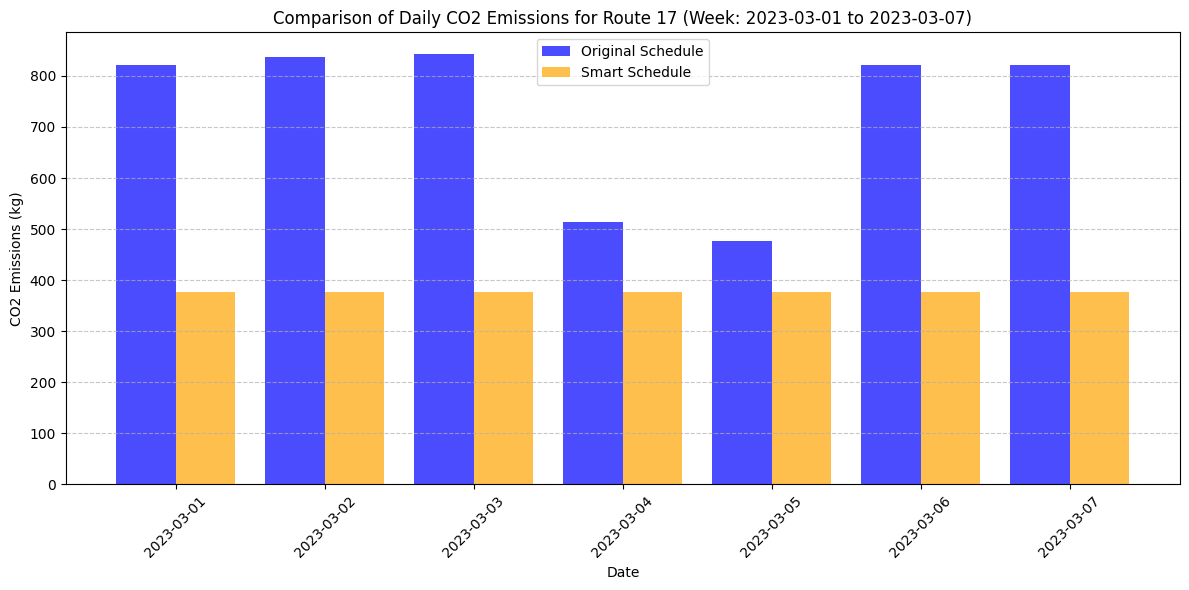

Number of trips in Original Schedule: 327
Number of trips in Smart Schedule: 175

Daily Emissions for Original Schedule:
Date: 2023-03-01, CO2 Emissions: 820.48 kg
Date: 2023-03-02, CO2 Emissions: 837.61 kg
Date: 2023-03-03, CO2 Emissions: 843.17 kg
Date: 2023-03-04, CO2 Emissions: 514.41 kg
Date: 2023-03-05, CO2 Emissions: 477.12 kg
Date: 2023-03-06, CO2 Emissions: 820.48 kg
Date: 2023-03-07, CO2 Emissions: 820.48 kg

Daily Emissions for Smart Schedule:
Date: 2023-03-01, CO2 Emissions: 377.26 kg
Date: 2023-03-02, CO2 Emissions: 377.26 kg
Date: 2023-03-03, CO2 Emissions: 377.26 kg
Date: 2023-03-04, CO2 Emissions: 377.26 kg
Date: 2023-03-05, CO2 Emissions: 377.26 kg
Date: 2023-03-06, CO2 Emissions: 377.26 kg
Date: 2023-03-07, CO2 Emissions: 377.26 kg


In [ ]:
# Specify route and week
selected_route_id = 17
week_start = dt.date(2023, 3, 1)
week_end = week_start + dt.timedelta(days=6)

# Original schedule data
route_data = filter_route_data(trips_df, selected_route_id, week_start, week_end)
route_data = apply_fuel_averages(route_data, avg_fuel_by_time)
original_emissions = calculate_weekly_average_co2(route_data, EMISSION_FACTOR)

# Smart schedule data
smart_schedule = generate_smart_schedule_with_fuel(
    route_id=selected_route_id,
    trips_df=trips_df,
    avg_fuel_by_time=avg_fuel_by_time,
    round_trip_time=20,
    peak_threshold=0.8,
    off_peak_threshold=0.4,
    ship_capacity=50
)
smart_schedule_route = [entry for entry in smart_schedule if week_start <= entry["date"] <= week_end]
predicted_emissions = calculate_weekly_predicted_co2(smart_schedule_route, EMISSION_FACTOR)

# Print original schedule
print("\nOriginal Weekly Schedule:")
print(route_data[["time_departure", "avg_fuel_outbound", "fuelcons_outbound_l", "fuelcons_inbound_l"]].to_string(index=False))

# Format the smart schedule for display
print("\nSmart Weekly Schedule:")
smart_schedule_df = pd.DataFrame(smart_schedule_route)

# Combine date and time to match the original schedule format
smart_schedule_df["time_departure"] = smart_schedule_df.apply(
    lambda row: dt.datetime.combine(row["date"], row["departure_time"]), axis=1
)

# Add dummy columns for fuel consumption to match the original schedule format
smart_schedule_df["avg_fuel_outbound"] = smart_schedule_df["predicted_fuel_consumption"]
smart_schedule_df["fuelcons_outbound_l"] = smart_schedule_df["predicted_fuel_consumption"] / 2 
smart_schedule_df["fuelcons_inbound_l"] = smart_schedule_df["predicted_fuel_consumption"] / 2  

# Select and reorder columns to match the original schedule
smart_schedule_formatted = smart_schedule_df[["time_departure", "avg_fuel_outbound", "fuelcons_outbound_l", "fuelcons_inbound_l"]]

# Print the formatted smart schedule
print(smart_schedule_formatted.to_string(index=False))

# Save schedules with route_id in filenames
original_filename = f"original_schedule_route_{selected_route_id}.csv"
smart_filename = f"smart_schedule_route_{selected_route_id}.csv"

# Save smart and original schedules
save_schedule_to_csv(smart_schedule, smart_filename)
save_schedule_to_csv(route_data, original_filename)

# Plot comparison
comparison_df = pd.DataFrame({
    "Date": pd.to_datetime(sorted(original_emissions["daily_co2_emissions"].keys())),
    "Original CO2 Emissions": list(original_emissions["daily_co2_emissions"].values()),
    "Predicted CO2 Emissions": [
        predicted_emissions["daily_co2_emissions"].get(date.strftime('%Y-%m-%d'), 0)
        for date in pd.to_datetime(sorted(original_emissions["daily_co2_emissions"].keys()))
    ]
})


plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(comparison_df))

plt.bar([pos - bar_width / 2 for pos in x], comparison_df["Original CO2 Emissions"], width=bar_width, label="Original Schedule", color='blue', alpha=0.7)
plt.bar([pos + bar_width / 2 for pos in x], comparison_df["Predicted CO2 Emissions"], width=bar_width, label="Smart Schedule", color='orange', alpha=0.7)

plt.xticks(x, comparison_df["Date"].dt.strftime("%Y-%m-%d"), rotation=45)
plt.xlabel("Date")
plt.ylabel("CO2 Emissions (kg)")
plt.title(f"Comparison of Daily CO2 Emissions for Route {selected_route_id} (Week: {week_start} to {week_end})")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Debugging: Print number of trips
print(f"Number of trips in Original Schedule: {len(route_data)}")
print(f"Number of trips in Smart Schedule: {len(smart_schedule_route)}")

# Debugging: Print daily emissions
print("\nDaily Emissions for Original Schedule:")
for date, emissions in original_emissions["daily_co2_emissions"].items():
    print(f"Date: {date}, CO2 Emissions: {emissions} kg")

print("\nDaily Emissions for Smart Schedule:")
for date, emissions in predicted_emissions["daily_co2_emissions"].items():
    print(f"Date: {date}, CO2 Emissions: {emissions} kg")

